# DC14

In [1]:
#i = 0   #kalo udah bisa, iterasi 20_000 burn in 5_000
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emcee
import corner
import math
from IPython.display import display, Math
from scipy.stats import norm

G = 4.2994e-6 # (km/s)**2 * kpc/Msun
H0 = 72 #km s^-1 Mpc^-1
delta_c = 200
h = H0/100
C = 1000  #Mpc to kpc

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Data #i nya yang diubah
galaxy_data = pd.read_csv('C:/Users/Azriel Julio Dante/Desktop/S2/Thesis/Olah Data/MCMCdataobs.csv', index_col=0)
rc_data= pd.read_csv('C:/Users/Azriel Julio Dante/Desktop/S2/Thesis/Olah Data/MCMCrcobs.csv', index_col=0)
i = 44
ID = galaxy_data.iloc[i]['Galaxy']
galaxy = galaxy_data[galaxy_data.Galaxy == ID]
rc = rc_data[rc_data['ID'] == ID].reset_index(drop=True)
rad = rc['R']
Dobs = galaxy_data.iloc[i]['D']
Dobs_err = galaxy_data.iloc[i]['e_D']
incobs = galaxy_data.iloc[i]['Inc']
incobs_err = galaxy_data.iloc[i]['e_Inc']
Vobs = rc['Vobs']
Vobs_err = rc['e_Vobs']
Vdisk = rc['Vdisk']
Vgas = rc['Vgas']
Vmax = rc['Vobs'].max()
Mstar = galaxy_data.iloc[i]['Mstar']
Mgas = 1.33* galaxy_data.iloc[i]['Mgas']
M_Ldisk_init = 0.5
Lstar = galaxy_data.iloc[i]['L']
print('ID = ',ID)
print('Npoint = ', len(rad))
print('Vmax = ',Vmax)
print('M/L_disk = '  , M_Ldisk_init)
print('inc = ',incobs)
print('inc_err = ',incobs_err)
print('D = ',Dobs)
print('D_err = ',Dobs_err)
print('Lstar = ',Lstar)
#initial param
alpha = 1
beta = 3
gamma = 1
V200_init = 0.8*Vmax
r200_init = 1000*V200_init/(H0*np.sqrt(delta_c/2))
M200_init = V200_init**2 *r200_init/(G)
log_C200_init = 0.830-(0.098*np.log10(M200_init/((10**(12))*(h**(-1)))))
C200_init = 10**log_C200_init
X = np.log10(Mstar/M200_init)
C200_DC14_init = C200_init *(1+0.0001*np.exp(3.4*(X+4.5)))
alpha = 2.94 - np.log10((10**(X+2.33))**-1.08 + (10**(X+2.33))**2.29)
beta = 4.23 + 1.34*X + 0.26*X**2
gamma = -0.06 + np.log10((10**(X+2.56))**-0.68 + 10**(X+2.56))
#rs = rmin2 / ((2-gamma)/(beta-2))**(1/alpha)
#x = r/rs
rs = r200_init / C200_DC14_init
M_Ldisk_init = 0.5
print('V200 = ',V200_init)
print('C200 = ',C200_init)
print('C200 DC14 = ',C200_DC14_init)
print('M200 = ',M200_init)
print('log M200 = ', np.log10(M200_init))
print('M/L_disk = '  , M_Ldisk_init)
print('rs = ',rs)
print('R200 = ',r200_init)

ID =  WLM
Npoint =  24
Vmax =  38.96
M/L_disk =  0.5
inc =  74.0
inc_err =  2.3
D =  0.985
D_err =  0.0985
Lstar =  49200000
V200 =  31.168000000000003
C200 =  10.98812376745322
C200 DC14 =  11.367780319847201
M200 =  9781072027.373331
log M200 =  9.99038645704299
M/L_disk =  0.5
rs =  3.808033553684186
R200 =  43.28888888888889


In [4]:
#MCMC
def main(p0, nwalkers, niter, ndim, ln_posterior, data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior, args=data)

    print("Running burn-in...")
    p0 = sampler.run_mcmc(p0, 3000, progress=True) #500 iterasi pertama ditetapkan sebagai burn-in
    sampler.reset() #reset sampler sebelum melakukan iterasi utama

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter, progress=True)

    return sampler, pos, prob, state

In [5]:
from scipy.integrate import quad

def betaincarray(a, b, x):
    betainc_list = []
    for val in x:
        upperbound = val
        integrand = lambda t: t**(a-1) * (1-t)**(b-1)
        betainc, _ = quad(integrand, 0, upperbound)
        betainc_list.append(betainc)
    return np.array(betainc_list)


def betainc(a, b, x):
    def integrand(t):
        return t**(a-1) * (1-t)**(b-1)
    result, _ = quad(integrand, 0, x)
    return result

In [6]:
# Halo DC14
def VDM(V200, C200,M_Ldisk,r): # parameter bebas ditetapkan V200 dan C200
    # V200 dan C200 adalah kecepatan dan konsentrasi pada R200, rs adalah skala radius
    rs = 1000 * V200 / (H0*C200*np.sqrt(delta_c/2)) #kpc dikali 1000
    x = r/rs
    r200 = C200*rs
    M200 = V200**2*r200/G
    Mstar = M_Ldisk*Lstar
    X = np.log10(Mstar/M200)
    alpha = 2.94 - np.log10((10**(X+2.33))**-1.08 + (10**(X+2.33))**2.29)
    beta = 4.23 + 1.34*X + 0.26*X**2
    gamma = -0.06 + np.log10((10**(X+2.56))**-0.68 + 10**(X+2.56))
    a = (3-gamma)/alpha
    b = (beta-3)/alpha
    e = (r/rs)**alpha / (1+(r/rs)**alpha)
    ec = (C200)**alpha / (1+(C200)**alpha)
    vh = V200*np.sqrt((C200/x) * ((betaincarray(a,b+1,e)+betaincarray(a+1,b,e))/(betainc(a,b+1,ec)+betainc(a+1,b,ec))))
    return vh



#Fungsi model kecepatan rotasi total
def Vtot(ML_d, vDM, Vdisk, Vgas):
    #ML_d adalah mass to light ratio komponen disk
    return np.sqrt(vDM**2 + ML_d*(Vdisk**2) + Vgas*np.abs(Vgas))

In [7]:
#Likelihood
def ln_likelihood(theta, r, Vobs, Vdisk, Vgas, Vobs_err):
    V200, C200, M_Ld = theta
    vDM = VDM(V200, C200, M_Ld,r)
    vtot = Vtot(M_Ld, vDM, Vdisk, Vgas)
    lik = np.sum(-np.log(np.sqrt(2*math.pi)*Vobs_err) - ((Vobs - vtot)**2)/(2*(Vobs_err**2)))
    return lik

#Prior
def ln_prior(theta):
    V200, C200, M_Ld = theta
    r200_pred = 1000*V200/ (H0*np.sqrt(delta_c/2))
    M200_pred = V200**2 * r200_pred /G
    log_C200_pred = 0.830-(0.098*np.log10(M200_init/((10**(12))*(h**(-1)))))
    C200_pred = 10**log_C200_pred
    X = np.log10(M_Ld*Lstar/M200_pred)
    C200_DC14 = C200_pred *(1+0.00001*np.exp(3.4*(X+4.5)))
    if 10.0 < V200 < 100.0: # km/s
        p1 = 1/150
    else:
        p1 = 0
    if 0.0 < C200 < 150:
        p2 = norm.pdf(x=C200,loc=C200_DC14,scale=(10**0.11-1))
    else:
        p2 = 0
    if 0.2 < M_Ld:
        p3 = norm.pdf(x=M_Ld, loc=0.5, scale=(10**0.1 - 1))
    else:
        p3 = 0
    
    return np.log(p1*p2*p3)

#Posterior
def ln_posterior(theta, r, Vobs, Vdisk, Vgas, Vobs_err):
    lp = ln_prior(theta)
    if not np.isfinite(lp):
        return -np.inf      
    return lp + ln_likelihood(theta, r, Vobs, Vdisk, Vgas, Vobs_err)

In [8]:
#Menjalankan MCMC
nwalkers = 35 #number of walkers
niter = 15000 #number of iterations #ganti 2000
init_param = np.array([V200_init, C200_DC14_init, M_Ldisk_init]) #V200, C200, M/L ambil semuanya secara sembarang dalam rentang prior
ndim = len(init_param) #number of dimension
p0 = [np.array(init_param) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)] #methodology of stepping from one place to a grid to the next

sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,ln_posterior,(rad, Vobs, Vdisk, Vgas, Vobs_err)) #run MCMC

Running burn-in...


100%|██████████| 3000/3000 [27:51<00:00,  1.79it/s]


Running production...


100%|██████████| 15000/15000 [3:31:27<00:00,  1.18it/s]  


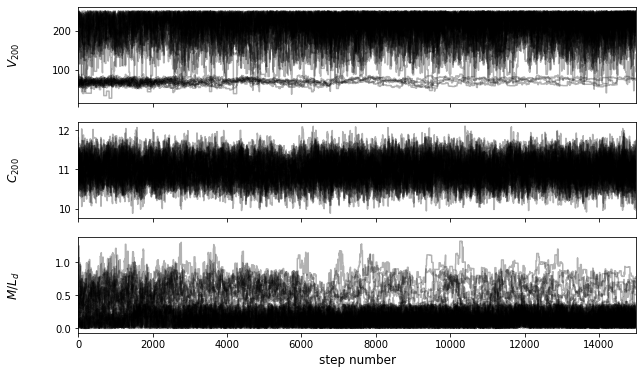

In [9]:
#Membuat plot masing-masing parameter (MCMC chains) untuk mengecek konvergensi
fig, axes = plt.subplots(ndim, figsize=(10, 6), sharex=True)
samples = sampler.get_chain()
labels = [r"$V_{200}$", r"$C_{200}$", r"$M/L_d$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i], fontsize=12)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number", fontsize=12);
plt.savefig('Trace plot {} (DC14).jpg'.format(rc.iloc[0]['ID']), bbox_inches = 'tight', dpi=300)

In [10]:
# Flat: concatenating the samples from each walker in the chain
# Discard: menghapus X sampel (flattened) pertama
# Thin: mengambil sampel kelipatan ke-X saja (untuk merampingkan sampel dan menghemat ukuran sampel)
flat_samples = sampler.get_chain(discard=3000, thin=15, flat=True)
np.savetxt("Flat samples {} (DC14).txt".format(rc.iloc[0]['ID']), np.c_[flat_samples[:, 0],flat_samples[:, 1],flat_samples[:, 2]])
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 300;
tau: [964.14204567 167.39385917 912.4587759 ]

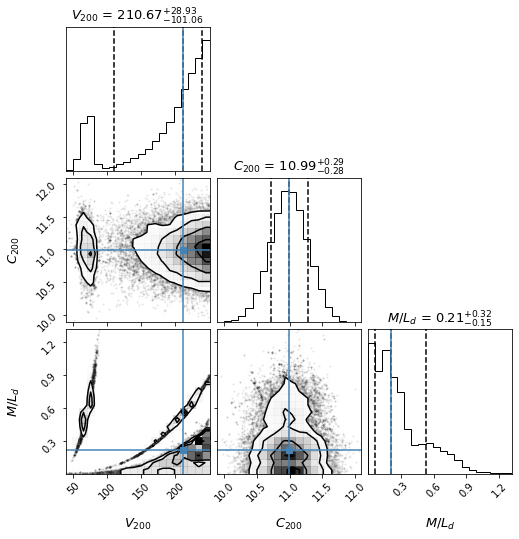

In [11]:
#Membuat corner plot
#Menyimpan nilai best-fit parameter hasil MCMC
flat_samples = np.loadtxt("Flat samples {} (DC14).txt".format(rc.iloc[0]['ID']))
labels = [r"$V_{200}$", r"$C_{200}$", r"$M/L_d$"]

V200 = np.median(flat_samples[:, 0])
C200 = np.median(flat_samples[:, 1])
ML_d = np.median(flat_samples[:, 2])

fig = corner.corner(flat_samples,show_titles=True,title_kwargs={"fontsize":13},labels=labels,label_kwargs={"fontsize":13},plot_datapoints=True,truths=[V200,C200,ML_d],quantiles=[0.16, 0.5, 0.84],dpi=200)
plt.savefig('Corner plot {} (DC14).jpg'.format(rc.iloc[0]['ID']), bbox_inches = 'tight', dpi=300)

In [12]:
#Menghitung kecepatan komponen halo DM dan kecepatan total menggunakan nilai best-fit
vDM = VDM(V200, C200, ML_d, rad)
vtot = Vtot(ML_d, vDM, Vdisk, Vgas)

In [13]:
#Menuliskan nilai best-fit parameter hasil MCMC dan reduced chi squared
labels2 = [r'V_{200}', r'C_{200}', r'M/L_d']
ndim = 3
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels2[i])
    display(Math(txt))

rsn = rs = 1000 * V200 / (H0*C200*np.sqrt(delta_c/2)) #kpc dikali 1000
trsn = "\mathrm r_{{s,NFW}} = {0:.3f} \, \\textrm{{kpc}}".format(rsn)
r200n = C200*rsn
tr200n = "\mathrm r_{{200,NFW}} = {0:.3f} \, \\textrm{{kpc}}".format(r200n)
display(Math(trsn))
display(Math(tr200n))

chisq = 0.
for i in range(len(rad)):
    chisq = chisq + (((Vobs[i] - vtot[i])**2)/(Vobs_err[i])**2)

red_chisq = chisq/(len(rad) - ndim) #reduced chi squared
txt2 = "\mathrm\chi_{{\\nu}}^2 = {0:.3f}".format(red_chisq)
display(Math(txt2))

#KS and SW test
from scipy import stats
residuals = (Vobs - vtot)/Vobs_err
ks_statistic, ks_p_value = stats.kstest(residuals, 'norm')
print("KS Statistic:", ks_statistic)
print("KS p-value:", ks_p_value)

# Perform Shapiro-Wilk test on residuals
shapiro_statistic, shapiro_p_value = stats.shapiro(residuals)
print("Shapiro-Wilk Statistic:", shapiro_statistic)
print("Shapiro-Wilk p-value:", shapiro_p_value)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

KS Statistic: nan
KS p-value: nan
Shapiro-Wilk Statistic: nan
Shapiro-Wilk p-value: nan


In [14]:
#Komponen kecepatan disk adalah akar dari (ML_d * (Vdisk**2)), dari Li et al. 2020
Vdisk_f = []
for i in range(len(rad)):
    vdisk_f = np.sqrt(ML_d) * (Vdisk[i]) #vdisk_f = np.sqrt(ML_d * Vdisk[i]**2)
    Vdisk_f.append(vdisk_f)
np.savetxt('Mass model {} (DC14).txt'.format(rc.iloc[0]['ID']), np.c_[rad,Vobs,Vobs_err,Vgas,Vdisk_f,vDM,vtot], fmt='% 1.3f', header='R     Vobs    eVobs  Vgas    Vdisk   VDM     Vtot')

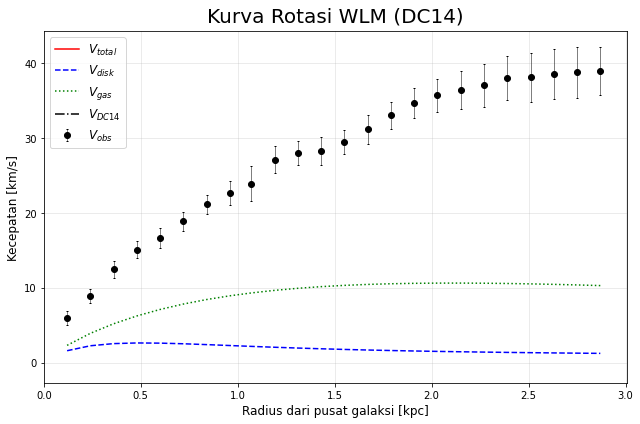

In [15]:
#Membuat plot kurva rotasi
plt.figure(figsize=(9,6))
#plt.axvline(x = rsn, c = 'orchid', linewidth = 1.0, linestyle = (5, (10, 3)), label = '$r_s$')
plt.plot(rad, vtot, label = '$V_{total}$', c = "red", linewidth = 1.5, linestyle = 'solid') # Komponen total
plt.errorbar(rad, Vobs, Vobs_err, label = '$V_{obs}$', elinewidth = 0.5, fmt = 'ko', capsize = 1) # Komponen teramati
plt.plot(rad, Vdisk_f, label = '$V_{disk}$', c = "blue", linewidth = 1.5, linestyle = 'dashed') # Komponen disk
plt.plot(rad, Vgas, label = '$V_{gas}$', c = "green", linewidth = 1.5, linestyle = 'dotted') # Komponen gas
plt.plot(rad, vDM, label = '$V_{DC14}$', c = "black", linewidth = 1.5, linestyle = 'dashdot') # Komponen DM
plt.title('Kurva Rotasi {} (DC14)'.format(rc.iloc[0]['ID']), pad=10, size=20)
plt.ylim(Vgas.min()-5,); plt.xlim(0,)
plt.xlabel('Radius dari pusat galaksi [kpc]', size=12)
plt.ylabel('Kecepatan [km/s]', size=12)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.grid(alpha = 0.3)
plt.savefig('Kurva Rotasi {} (DC14).jpg'.format(rc.iloc[0]['ID']), bbox_inches = 'tight', dpi = 300)
plt.show()